# Analyzing aperiodic activity in resting state data with spectral parameterization


### Aperiodic activity has largely been ignored, and the focus has been on oscillatory activity

So, how do we derive aperiodic activity in resting state data (including sleep). EEG is a very popular imaging method, thus we will mimic that in this notebook.

In this notebook, we show an example of how you can compare aperiodic measurements from 2 different people. One diagnosed with PD, and another age-matched healthy control. 

### Spectral parameterization

This technique differentiates between oscillatory activity and aperiodic activity.
REF to paper

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

The data used in this notebook comes from:
[Wan et al., 2021](https://openneuro.org/datasets/ds003754/versions/1.0.2) JK not this one, I don't see the preprocessed data

[UCSD resting state in parkinson EEG](https://openneuro.org/datasets/ds002778/versions/1.0.5)

(No not this one either) Or this one: [Hatlestad-Hall - resting EEG](https://openneuro.org/datasets/ds003775/versions/1.2.1)

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [58]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from neurodsp.sim import sim_powerlaw, sim_random_walk, sim_oscillation, sim_bursty_oscillation
from neurodsp.sim import sim_combined 
# from neurodsp.sim import sim_peak_oscillation <-- pip install upgrade once this version is released
from neurodsp.utils import set_random_seed
from neurodsp.spectral import compute_spectrum #, rotate_powerlaw
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
from neurodsp.plts import plot_timefrequency
from neurodsp.timefrequency import amp_by_time, phase_by_time
from neurodsp.sim.utils import rotate_timeseries
from neurodsp.timefrequency import compute_wavelet_transform

from fooof import FOOOF



In [4]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [5]:
import seaborn as sns
sns.set_context('poster')

In [6]:
# Set random seed
set_random_seed(808)

In [7]:
# Set whether to save out figures
SAVE_FIG = False

### Conclusion

<>

## Import dataset

Shape of data is 3 rows and n time points.

1st row = pd data 

2nd row = hc data 

3rd row = time data 

sampling frequency = 512 Hz


In [229]:
data = np.load('../data/resting_eeg.npy')
fs = 512

# 5 second snippet of data
start = 512 # data.shape[1]//2
end = start + 120 * fs

# take only a middle portion of the data for illustration
data_short = data[:,start:end]

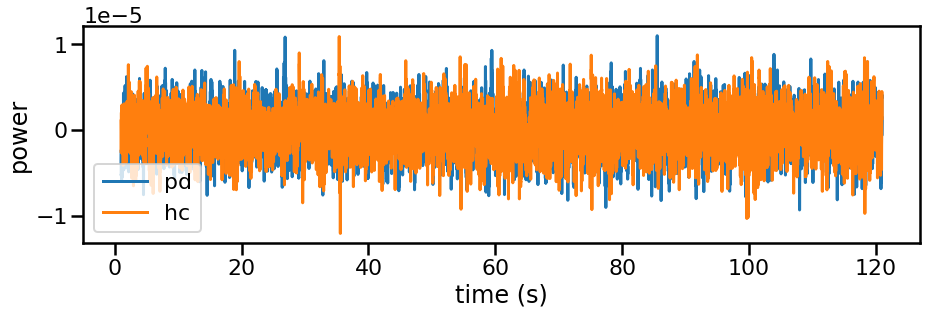

In [230]:
# plot time series
plt.figure(figsize=(15,4))

plt.plot(data_short[2], data_short[0], label='pd')
plt.plot(data_short[2], data_short[1], label='hc')
plt.xlabel('time (s)')
plt.ylabel('power')
plt.legend()
plt.show()

## Create power spectra and apply spectral parameterization to extract aperiodic activity

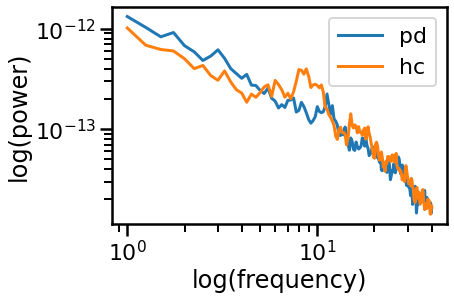

In [241]:
# First we need to create a power spectrum
# with 2 second windows and 1 second of overlap, in the frequency range of how the data was filtered
freqs, pd_psd = compute_spectrum(data_short[0], fs, nperseg=fs*4, noverlap=fs*2, f_range=[1,40])
freqs, hc_psd = compute_spectrum(data_short[1], fs, nperseg=fs*4, noverlap=fs*2, f_range=[1,40])

        
plt.loglog(freqs, pd_psd, label='pd')
plt.loglog(freqs, hc_psd, label='hc')
plt.legend()
plt.xlabel('log(frequency)')
plt.ylabel('log(power)')
plt.show()

In [242]:
# Create model
pd_model = FOOOF(**SETS_FOOOF)
hc_model = FOOOF(**SETS_FOOOF)

# fit model
pd_model.fit(freqs, pd_psd, freq_range=FREQ_RANGE)
hc_model.fit(freqs, hc_psd, freq_range=FREQ_RANGE)

In [243]:
# inspect model fit of pd person
pd_model.print_settings(description=True)
print('r-squared: \t', pd_model.r_squared_)

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [2, 8]                                    
                        Limits for minimum and maximum peak widths, in Hz.                        
                                    Max Number of Peaks : inf                                     
                          Maximum number of peaks that can be extracted.                          
                                    Minimum Peak Height : 0.2                                     
                Minimum absolute height of a peak, above the aperiodic component.                 
                                       Peak Threshold: 2.0                                        
          

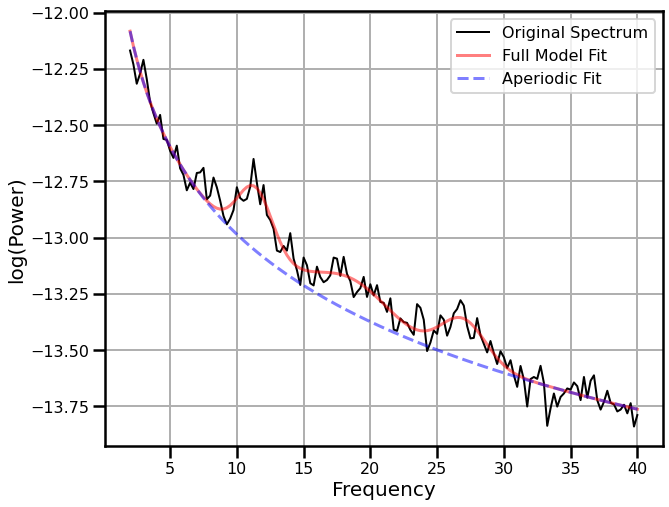

In [244]:
pd_model.plot()

In [245]:
# inspect model fit of hc person
hc_model.print_settings(description=True)
print('r-squared: \t', hc_model.r_squared_)

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [2, 8]                                    
                        Limits for minimum and maximum peak widths, in Hz.                        
                                    Max Number of Peaks : inf                                     
                          Maximum number of peaks that can be extracted.                          
                                    Minimum Peak Height : 0.2                                     
                Minimum absolute height of a peak, above the aperiodic component.                 
                                       Peak Threshold: 2.0                                        
          

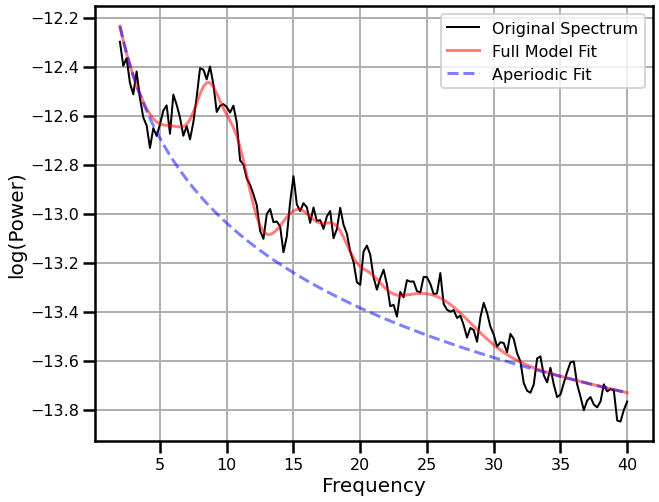

In [246]:
hc_model.plot()

### interim summary:
Now that we have visually inspected the model fit, and printed the r_squared values. We can see that the full model accurately fits original spectrum. Which means we can proceed to extract the aperiodic exponent and offset

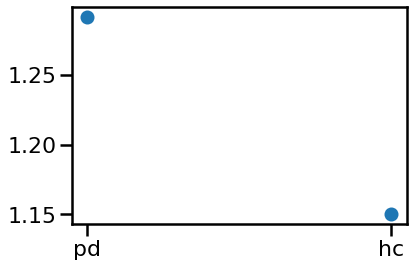

In [247]:
# we now extract the aperiodic components (offset, exponent)
pd_aperiodic = pd_model.aperiodic_params_
hc_aperiodic = hc_model.aperiodic_params_

plt.scatter(['pd', 'hc'], [pd_aperiodic[1], hc_aperiodic[1]])
plt.show()

## I tried to do some simulation here with a steeper and flatter spectrum, but we might just need to delete it from this notebook if it's not really serving a purpose now that I'm using real data

In [18]:
# Settings for simulation
N_MINUTES = 2
N_SECONDS = 60 * N_MINUTES
FS = 250
TIMES = create_times(N_SECONDS, FS)

# Define oscillation frequency
OSC_FREQ = 10 # alpha

# Burst settings
ENTER_BURST = 0.1
LEAVE_BURST = 0.1

Now we'll set the parameters for the spectral parameterization algorithm. It is necessary to choose appropriate settings for fitting oscillations. If oscillations are not appropriately fit, it will negatively affect the aperiodic fit. 
In a later notebook, we will discuss how to appropriately choose parameter settings. For now, since this is just an example of resting state analysis, we'll use the settings as mentioned below. 

In [19]:
# Settings for spectral parameterization
SETS_FOOOF = {'peak_width_limits': [2, 8], 'min_peak_height': 0.2} 
FREQ_RANGE = [2, 40] # might need to change this based on what comes next

### Simulate awake resting state // Or get the spectogram that is simulated in 00-notebook

In [46]:
burst = sim_bursty_oscillation(N_SECONDS, FS, OSC_FREQ,
                               enter_burst=ENTER_BURST,
                               leave_burst=LEAVE_BURST)

aperiodic_steep = sim_powerlaw(N_SECONDS, FS, exponent=-2)
aperiodic_flat = sim_powerlaw(N_SECONDS, FS, exponent=-1.5)

burst_signal_steep = aperiodic_steep + burst
burst_signal_flat = aperiodic_flat + burst


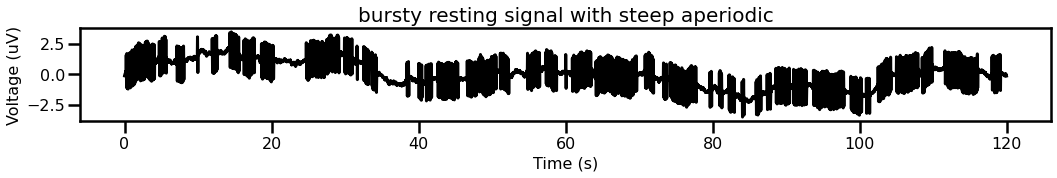

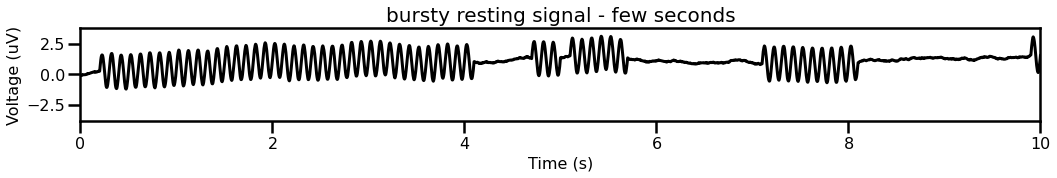

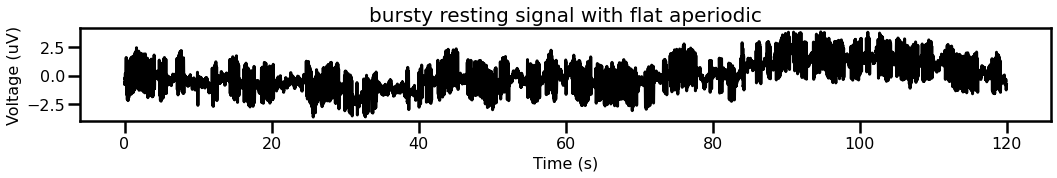

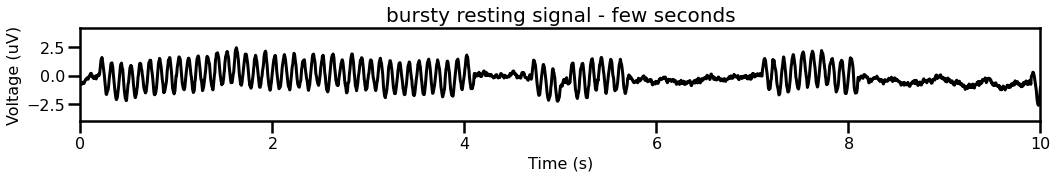

In [47]:
# Show the simulated time series with bursty alpha and aperiodic
plot_time_series(TIMES, burst_signal_steep, title='bursty resting signal with steep aperiodic')
plot_time_series(TIMES, burst_signal_steep, xlim=[0, 10], title='bursty resting signal - few seconds')

# Show the simulated time series with bursty alpha and aperiodic
plot_time_series(TIMES, burst_signal_flat, title='bursty resting signal with flat aperiodic')
plot_time_series(TIMES, burst_signal_flat, xlim=[0, 10], title='bursty resting signal - few seconds')

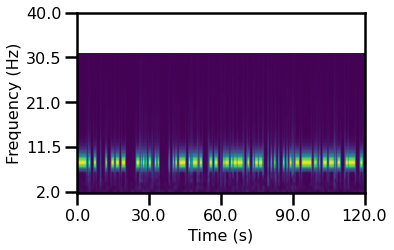

In [48]:
# Show spectogram
spectogram_steep = compute_wavelet_transform(burst_signal_steep, FS, FREQ_RANGE)
freqs = np.linspace(FREQ_RANGE[0], FREQ_RANGE[1])
# plot spectogram
plot_timefrequency(TIMES, freqs, spectogram_steep)

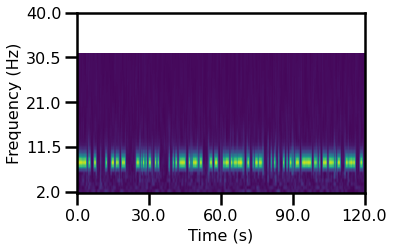

In [49]:
# Show spectogram
spectogram_flat = compute_wavelet_transform(burst_signal_flat, FS, FREQ_RANGE)
freqs = np.linspace(FREQ_RANGE[0], FREQ_RANGE[1])
# plot spectogram
plot_timefrequency(TIMES, freqs, spectogram_flat)

### Use spectral parameterization on resting state data

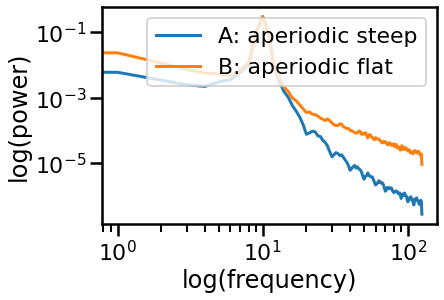

In [56]:
# First we need to create a power spectrum
freqs, spectrum_steep = compute_spectrum(burst_signal_steep, FS)
freqs, spectrum_flat = compute_spectrum(burst_signal_flat, FS)

plt.loglog(freqs, spectrum_steep, label='A: aperiodic steep')
plt.loglog(freqs, spectrum_flat, label='B: aperiodic flat')
plt.legend()
plt.xlabel('log(frequency)')
plt.ylabel('log(power)')
plt.show()

### Apply spectral parameterization on both spectra

In [61]:
# Create model
cond_A = FOOOF(**SETS_FOOOF)
cond_B = FOOOF(**SETS_FOOOF)

# fit model
cond_A.fit(freqs, spectrum_steep, freq_range=FREQ_RANGE)
cond_B.fit(freqs, spectrum_flat, freq_range=FREQ_RANGE)

# Extract aperiodic offset and exponent
